In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from IPython.display import clear_output
from torch.distributions.categorical import Categorical
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

In [113]:
data = pd.read_csv('horror.csv')
data.head()

,movie_id,movie_name,year,certificate,runtime,genre,rating,description,director,director_id,star,star_id,votes,gross(in $)
0,tt15679400,Knock at the Cabin,2023,R,100 min,"Horror, Mystery, Thriller",6.4,"While vacationing, a girl and her parents are ...",M. Night Shyamalan,/name/nm0796117/,"Dave Bautista, \nJonathan Groff, \nRupert Grin...","/name/nm1176985/,/name/nm2676147/,/name/nm0342...",17991.0,NaN
1,tt9764362,The Menu,2022,R,107 min,"Horror, Thriller",7.2,A young couple travels to a remote island to e...,Mark Mylod,/name/nm0617042/,"Ralph Fiennes, \nAnya Taylor-Joy, \nNicholas H...","/name/nm0000146/,/name/nm5896355/,/name/nm0396...",232052.0,NaN
2,tt8760708,M3GAN,2022,PG-13,102 min,"Horror, Sci-Fi, Thriller",6.4,A robotics engineer at a toy company builds a ...,Gerard Johnstone,/name/nm2067421/,"Allison Williams, \nViolet McGraw, \nRonny Chi...","/name/nm4129745/,/name/nm8627157/,/name/nm5307...",62458.0,NaN
3,tt13051810,Viking Wolf,2022,TV-MA,97 min,"Horror, Thriller",5.1,Thale (17) has just moved with her parents to ...,Stig Svendsen,/name/nm1457169/,"Liv Mjönes, \nElli Rhiannon Müller Osborne, \n...","/name/nm1203571/,/name/nm9602953/,/name/nm7416...",3872.0,NaN
4,tt10365998,Infinity Pool,2023,R,117 min,"Crime, Horror, Mystery",6.5,James and Em Foster are enjoying an all-inclus...,Brandon Cronenberg,/name/nm0188722/,"Alexander Skarsgård, \nMia Goth, \nCleopatra C...","/name/nm0002907/,/name/nm5301405/,/name/nm1671...",6955.0,NaN


In [114]:
data.shape

(36682, 14)

In [121]:
def clean_descriptions(desc_col: pd.Series) -> list[str]:
    return desc_col.str.lower().str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.split().str.join(' ').tolist()

In [122]:
descriptions = clean_descriptions(data['description'])
print(descriptions[:2])

['while vacationing a girl and her parents are taken hostage by armed strangers who demand that the family make a choice to avert the apocalypse', 'a young couple travels to a remote island to eat at an exclusive restaurant where the chef has prepared a lavish menu with some shocking surprises']


In [125]:
class DescriptionsDataset(Dataset):
    def __get_vocab(self, words: list[str]) -> dict[str, int]:
        vocab = {word: idx for idx, word in enumerate(words)}
        return vocab


    def __init__(self, preprocessed_descriptions: list[str]):
        self.specials = ['<pad>', '<bos>', '<eos>']

        self.descriptions = preprocessed_descriptions

        words = list(set(word for s in preprocessed_descriptions for word in s.split())) + ['<pad>', '<bos>', '<eos>']
        self.words = words
        self.vocab = self.__get_vocab(words)

        self.pad_index = self.vocab['<pad>']
        self.bos_index = self.vocab['<bos>']
        self.eos_index = self.vocab['<eos>']

        self.max_len = max(len(s.split()) for s in preprocessed_descriptions) + 2


    def __len__(self):
        return len(self.descriptions)


    def __str_to_idx(self, s: list[str]) -> torch.Tensor:
        return torch.tensor([self.vocab[word] for word in s])


    def encode(self, descr: str) -> torch.Tensor:
        return self.__str_to_idx(['<bos>'] + descr.split() + ['<eos>'])


    def __idx_to_str(self, idx: torch.Tensor) -> list[str]:
        return [self.words[i] for i in idx.tolist()]


    def decode(self, idx: torch.Tensor) -> str:
        words = self.__idx_to_str(idx)
        return ' '.join(w for w in words if w not in self.specials)


    def __getitem__(self, item):
        descr: str = self.descriptions[item]
        descr_encoded = self.encode(descr)
        descr_encoded_padded = torch.full((self.max_len, ), self.pad_index)
        descr_encoded_padded[:len(descr_encoded)] = descr_encoded
        return descr_encoded_padded, len(descr_encoded)

In [127]:
ds = DescriptionsDataset(descriptions)
dl = DataLoader(ds, 32, True)

In [128]:
for descrs, descrs_len in dl:
    print(descrs[:2])
    print(descrs_len[:2])
    break

tensor([[33222, 17041,  1132,  9963, 33223, 33221, 33221, 33221, 33221, 33221,
         33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221,
         33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221,
         33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221,
         33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221,
         33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221,
         33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221,
         33221, 33221, 33221, 33221, 33221, 33221, 33221, 33221],
        [33222, 16850,  7472, 15272,  1132,  3264, 11904, 12788, 24042, 16098,
          2643, 15268, 21835, 26653,  9954, 12604,  2614,  9954, 22218,  2260,
         26893,  9954,  7904, 12068, 26720, 16387, 33086, 24109, 20160, 28458,
         19244,  1174, 15255, 13885, 22793, 32005,   837, 29535,  9954, 12604,
         33223, 33221, 33221, 33221, 33221, 33221, 33221, 33221, 

In [98]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [137]:
class DescriptionGenerator(nn.Module):
    def __init__(self, dataset: DescriptionsDataset, embed_dim=32, hidden_dim=32, max_len=None):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=len(dataset.vocab),
            embedding_dim=embed_dim,
            padding_idx=dataset.pad_index
        )
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, len(dataset.vocab))
        self.dataset = dataset
        self.max_len = dataset.max_len if max_len is None else max_len


    def forward(self, tokens, lengths):
        embeds = self.embedding(tokens)
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed_embeds)
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.linear(outputs)
        return logits


    @torch.no_grad()
    def inference(self, prefix=''):
        tokens = self.dataset.encode(prefix)[:-1].unsqueeze(0).to(device)

        embeds = self.embedding(tokens)
        output, hidden = self.rnn(embeds)
        logits = self.linear(output)

        new_tokens = Categorical(logits=logits[:, -1:]).sample()
        tokens = torch.cat([tokens, new_tokens], dim=1)

        while tokens.shape[1] < self.max_len:
            if new_tokens.item() == self.dataset.eos_index:
                break

            embeds = self.embedding(new_tokens)
            output, hidden = self.rnn(embeds, hidden)
            logits = self.linear(output)
            new_tokens = Categorical(logits=logits[:, -1:]).sample()
            tokens = torch.cat([tokens, new_tokens], dim=1)

        return self.dataset.decode(tokens.squeeze())

In [142]:
model = DescriptionGenerator(ds, embed_dim=32, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=ds.pad_index)

In [143]:
[model.inference('aged') for _ in range(1)]

['aged acquired relieved fiadh bygone norway concentrating ragging ciliwung banion hurt cyclone reinforcements mixtapes awkward straightest saudi societies umm dallas lucie venetian arduous piss americana insidious blizzard seclude burglaralarm sect esther enlarged anointed docudrama nova cinematographers violents avengers comedian arcanum mller padmashree hurls spencer ceramic leaded derail consumption rosen erupted novelists rise ghostly lengths maim senseless mekarsari gentle tongueincheek slated leons horrorscary bacic bleeding apparent robar horrortalk thin mohab motherhood vieux diaperclad yurei perceive arson bot filmen bautista']

In [144]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

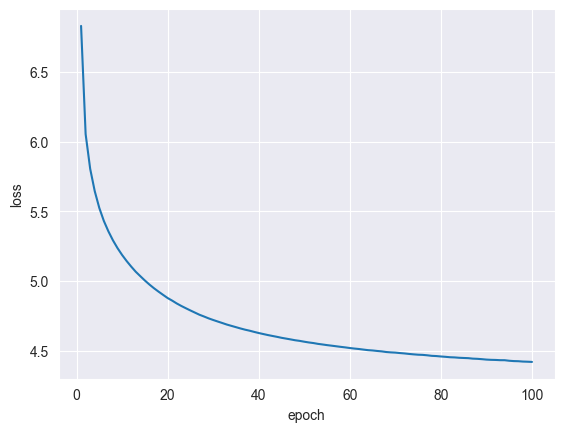

In [145]:
losses = []
num_epochs = 100

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    model.train()
    for tokens, lengths in dl:
        optimizer.zero_grad()
        tokens = tokens[:, :lengths.max()].to(device)
        logits = model(tokens[:, :-1], lengths - 1)
        loss = criterion(logits.transpose(1, 2), tokens[:, 1:])
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * tokens.shape[0]

    losses += [running_loss / len(ds)]

    if epoch % 10 == 0:
        print(epoch)
        plot_losses(losses)

In [146]:
[model.inference() for _ in range(1)]

['a young woman and his horror films leads a documentary monster at what begins experiencing this weekend plastic manner of the haunt to be haunted by the evil spirit of the school to win her see full summary']

In [147]:
[model.inference('aged') for _ in range(1)]

['aged how very glamour singer of a real mother turns deep infected with multiple basement he doesnt mean will soul behind a good dress by degree for way he is plunged into the city a local priest and one by report in an angloamerican range home the film happening all']